# SCABox Notebook Demo

<img src="media/SCAbox_logo.png" alt="drawing" width="200"/>

**SCAbox enable software based side-channel attacks on FPGA platforms**



In [42]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from scabox import *

## Connecting to the board through serial interface

<img src="media/picture_zybo.png" alt="drawing" width="300"/>

In [44]:
zb = ZyboSerial(port="COM7",baudrate=921600, timeout=1)

Successfully connected to Zybo through port COM7


## AES Attack Demo

Two tenants are located within the FPGA

<img src="media/threat.png" alt="drawing" width="600"/>

### Acquiring traces

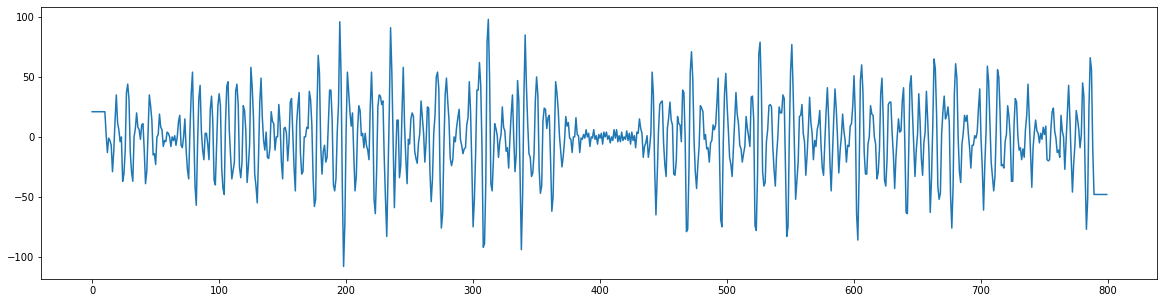

In [45]:
mode = "ssl"
n_trace = 1
n_sample = 800

samples = np.zeros((n_sample))
i_trace = 0 

while i_trace < n_trace:
    print("Acquired traces: %d/%d\r"%(i_trace,n_trace),end="")
    res,data = ZyboEncrypt.encrypt(zb.zybo,mode,[0]*16,[0]*16,s_min=0,s_max=n_sample)
    if not res: 
        samples += data
        i_trace+=1

plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(samples);

### CPA on hardware AES

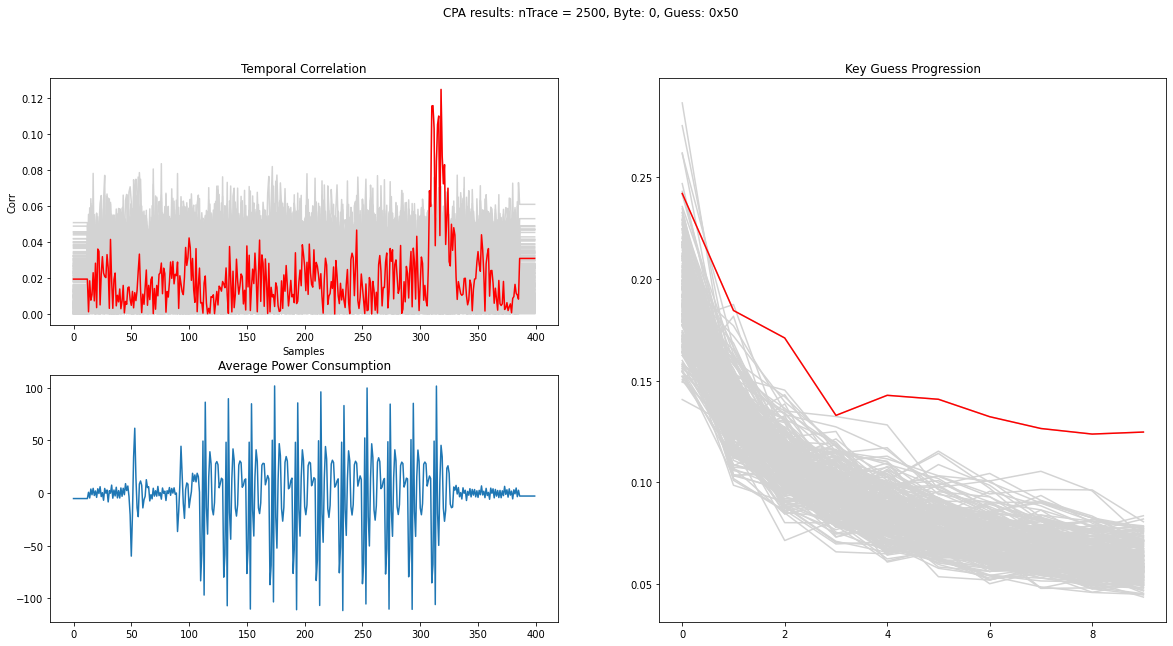

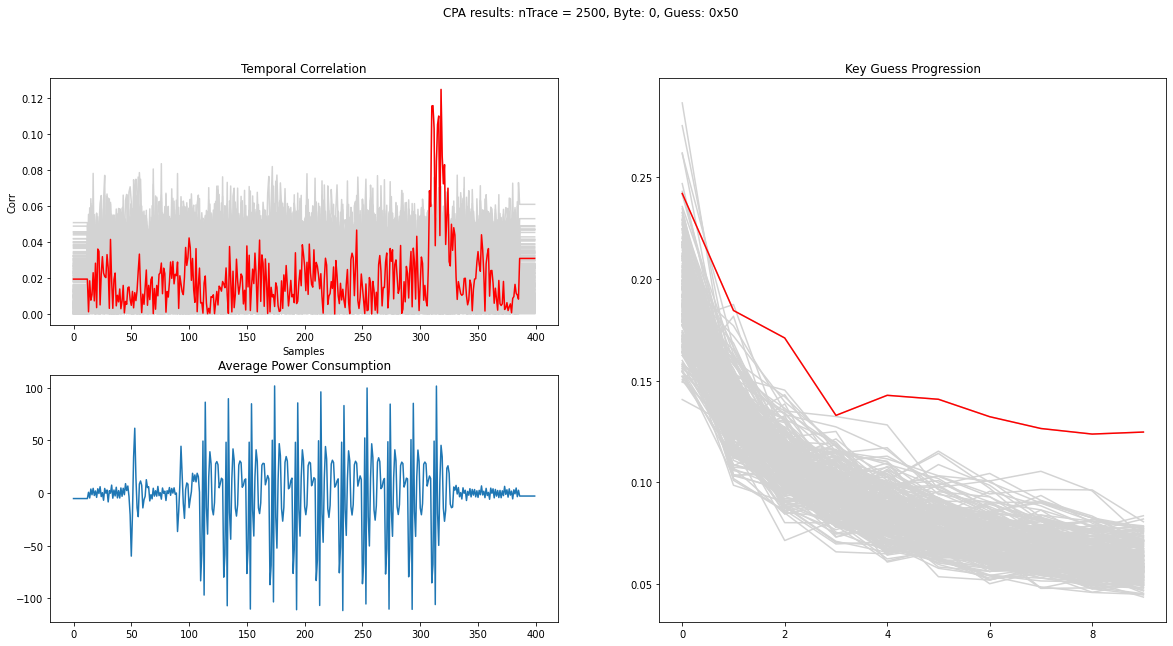

In [46]:
Demo.hw_aes_cpa_demo(zb,i_byte=0,n_trace=2500,n_sample=400,chunk_size=250)

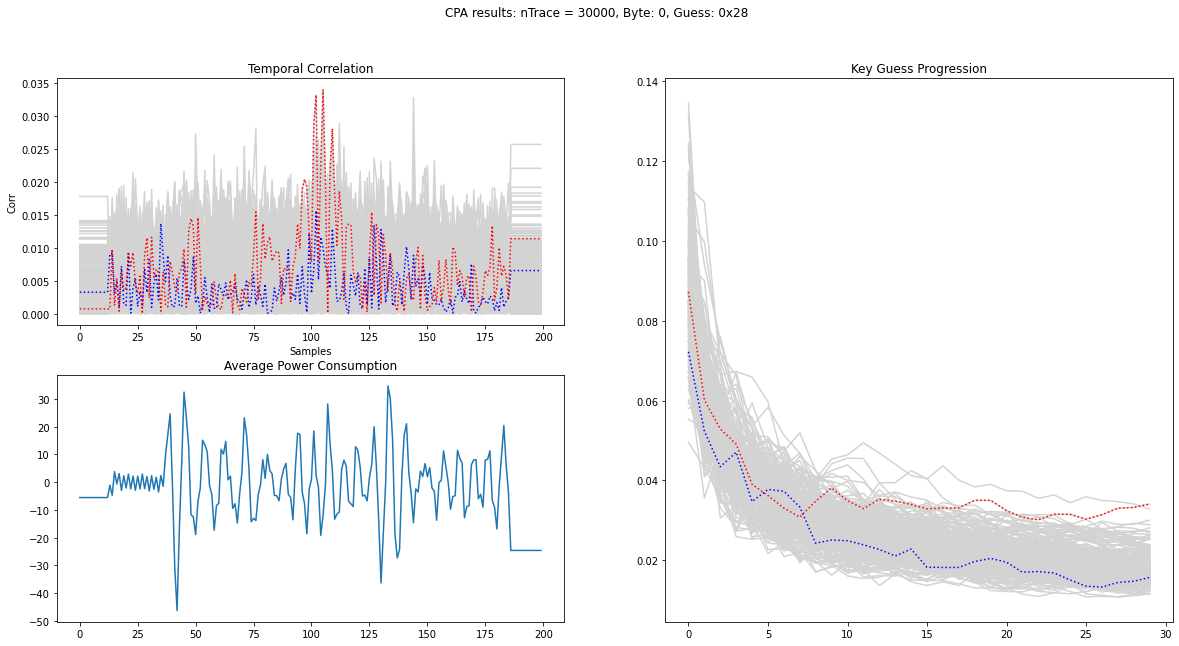

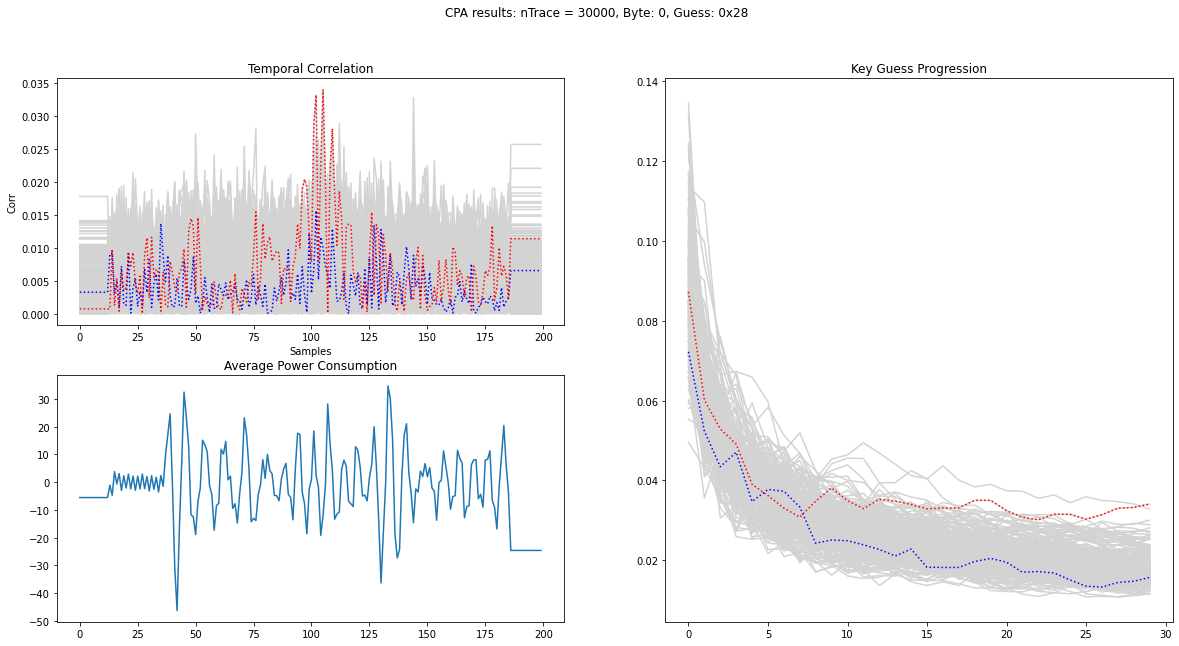

In [21]:
mode = "ssl"
n_trace = 30000
s_range = 0,200
i_byte = 0

chunk_size = 1000
n_chunk = n_trace // chunk_size

cpa_class = ClassCPA(256,s_range,n_chunk)
                         
for i_chunk in range(n_chunk):
    
    messages,ciphers,traces,key = ZyboEncrypt.get_leakage(zb.zybo,mode,n_trace=chunk_size,s_range=s_range,chunk_size=chunk_size,use_filt=True,time_out=5)
    cpa_class.accumulate(traces,messages,i_byte)
    corr = cpa_class.correlate(AESSelectionFct.sbox_k_xor_m,n_hyp=256,hw=True,mask=0xFF)
    cpa_class.plot_corr(corr,0x4d,chunk_size*(i_chunk+1),i_byte,i_chunk)

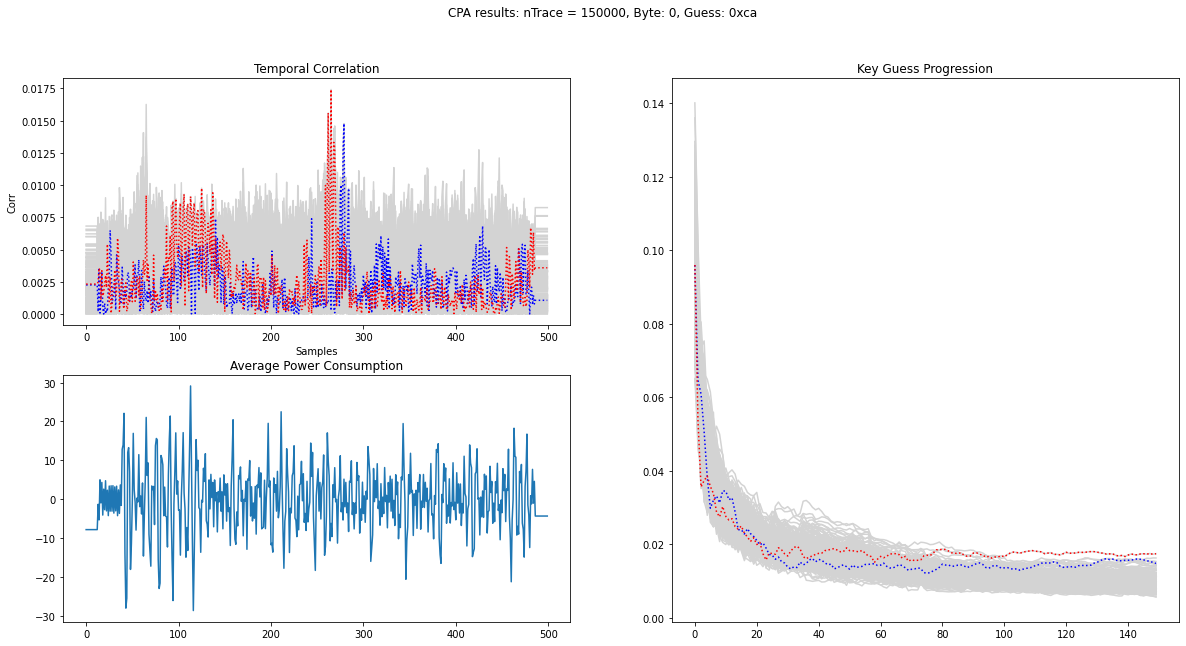

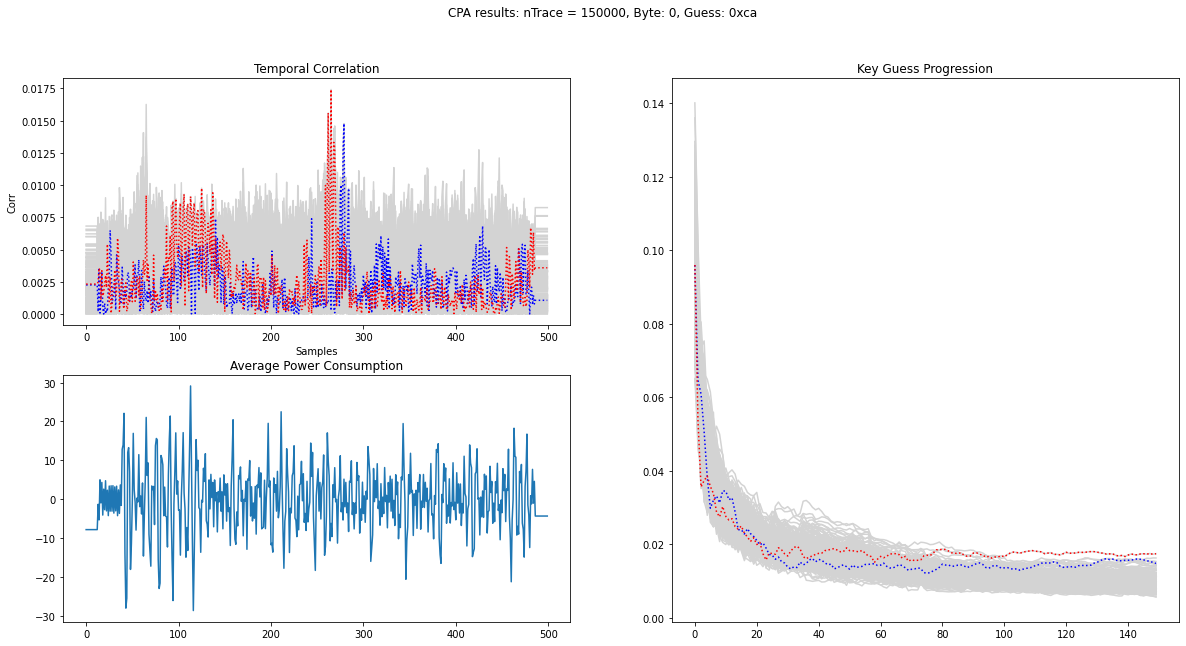

In [114]:
mode = "tiny"
n_trace = 150000
s_range = 0,500
i_byte = 0

chunk_size = 1000
n_chunk = n_trace // chunk_size

cpa_class = ClassCPA(256,s_range,n_chunk)
                         
for i_chunk in range(n_chunk):
    
    messages,ciphers,traces,key = ZyboEncrypt.get_leakage(zb.zybo,mode,n_trace=chunk_size,s_range=s_range,chunk_size=chunk_size,use_filt=True)
    cpa_class.accumulate(traces,messages,i_byte)
    corr = cpa_class.correlate(AESSelectionFct.sbox_k_xor_m,n_hyp=256,hw=True,mask=0xFF)
    cpa_class.plot_corr(corr,0x4d,chunk_size*(i_chunk+1),i_byte,i_chunk)

In [ ]:
corr = CPA.simple_cpa(AESSelectionFct.invsbox_k_xor_m___xor___m,traces,ciphers[:,0],n_hyp=256,hw=True,mask=0xFF)
plt.plot(corr.transpose());

In [ ]:
pp.plot(corr);

In [ ]:
corr = CPA.simple_cpa(AESSelectionFct.sbox_k_xor_m,traces,messages[:,0],n_hyp=256,hw=True,mask=0xFF)
plt.plot(corr.transpose());


In [106]:
print("message: %s"%"".join(["%02x"%e for e in messages[0]]))
print("cipher: %s"%"".join(["%02x"%e for e in ciphers[0]]))
print("key: %s"%"".join(["%02x"%e for e in key]))

message: 4b3087bf391c374676a0228f2bc99b04
cipher: 3927845597a8951fd39612402c0a668c
key: 4df8cb6970ba327f2ebfb7d219a21a6b


In [ ]:
pp.plot(traces[0])